In [1]:
## IPython extension to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
from matplotlib import pyplot as plt

import os
from os.path import join
import sys
import pickle
from IPython.display import display
from PIL import Image

ROOT_DIR = os.sep.join(os.path.abspath('.').split(os.sep)[:-2])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/data".format(ROOT_DIR)
print(DATASET_DIR)

/home/djoy2409-wsl/projects/software_development/qsar_w_gnns/data


In [3]:
from typing import List, Union, Any, Tuple
from datetime import datetime
from random import sample

import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch_geometric
from torch_geometric.data import Data
from torch.nn import BCELoss, LeakyReLU, ReLU
from torch.optim import lr_scheduler,Adagrad, Adadelta, Adam, AdamW

from rdkit import Chem, RDLogger
from rdkit.Chem import Draw, AllChem, PandasTools, MolFromSequence, MolToSmiles, MolToInchiKey, Descriptors, GraphDescriptors
from rdkit.Chem import rdMolDescriptors as rdmdesc

from joblib import Parallel, delayed

RDLogger.DisableLog('rdApp.*')
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from lib import gnn_utils, utilities, datasets, splitters, featurizers, training_utils, graph_nns, graph_utils


from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler


<p style="font-family: cursive; font-size=14px">
In the following, we will train regression models to predict the percentage of inhibition of the <em>P. falciparum's</em> DD2 growth.
</p>

<h3 style="font-family: cursive">Data Preparation</h4>

<h4 style="font-family: cursive">Dataset Cleaning</h4>
<p style="font-family: cursive; font-size=14px">
The dataset was obtained from the PubChem Biossay AID 2302. It was used as example in the paper by [Chakravarti and Mani Alla (2019); Frontiers in Artificial Intelligence, 2, DOI: 10.3389/frai.2019.00017](https://www.frontiersin.org/articles/10.3389/frai.2019.00017/full). </p>


In [4]:
dd2_data_df   = pd.read_csv(f"{DATASET_DIR}/dd2_inhibition_pubchem_aid_2302.csv") #.sample(n=1000)
smiles_column = "PUBCHEM_EXT_DATASOURCE_SMILES"
# target_column = "PCT_INHIB_DD2"
target_column = "DD2_ACTIVITY_CLS"
mol_column    = 'RMol'

print(f"Number of molecules with a missing SMILES string: {dd2_data_df[smiles_column].isna().sum()}/{dd2_data_df.shape[0]}")

# Removing rows with a missing SMILES string
dd2_data_df.dropna(subset=[smiles_column], axis=0, inplace=True)


# Remove rows where is not defined
dd2_data_df.dropna(subset=['PUBCHEM_ACTIVITY_OUTCOME'], axis=0, inplace=True)

# Add a column with 0/1 activity values
dd2_data_df[target_column] = dd2_data_df['PUBCHEM_ACTIVITY_OUTCOME'].apply(lambda x: 1 if x =='Active' else 0)


# Adding molecule (Mol) objects to the dataframe
PandasTools.AddMoleculeColumnToFrame(dd2_data_df, smiles_column, mol_column)

dd2_data_df.head(2)

Number of molecules with a missing SMILES string: 13/13533


,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PCT_INHIB_DD2,DD2_ACTIVITY_CLS,RMol
0,85857918,11957475.0,C1CN(CCN1CC(C(C2=CC=CC=C2)C3=CC=CC=C3)O)C4=CC(...,Inactive,4.0,0,<rdkit.Chem.rdchem.Mol object at 0x7f0b7b063dd0>
1,85857919,6618861.0,C1CN(CC=C1C2=CNC3=CC=CC=C32)CC4=CC=CC=C4,Active,80.0,1,<rdkit.Chem.rdchem.Mol object at 0x7f0b7b063eb0>


<span style="font-family: cursive; font-size=16px">
Beside removing rows with an empty SMILES, we will proceed with the following steps:
<ol>
    <li>Select the largest fragment for each molecule, which will also remove slats, among others. We will use the SMILES and inchikeys of the fragment.</li>
    <li>Sanitize the retained molecule</li>
    <li>Fix the target values. Negative values are set to 0 and values greater than 100 are set to 100</li>
    <li>Remove duplicates, using the inchikey as primary key. For each group of duplicates: </li>
        <ol>
            <li>If the min and max values are apart by 20 or more, omit and proceed to the next group</li>
            <li>Else, retain the first occurrence but replace the target value by an average</li>
            <li>It is worth mentioning that duplicate removal is usually a more involved process, where outliers can be detected and removed using a statisical approach, before averaging the taarget value.</li>
        </ol>
</ol>
</span>

In [5]:
dd2_data_df['largest_frag']        = dd2_data_df[mol_column].apply(utilities.get_largest_fragment_from_mol)

dd2_data_df['largest_frag_smiles'] = dd2_data_df['largest_frag'].apply(lambda mol: MolToSmiles(utilities.sanitize_molecule(mol, add_explicit_h=True)))

dd2_data_df.dropna(subset=['largest_frag_smiles'], axis=0, inplace=True)


dd2_data_df['largest_frag_ikey'] = dd2_data_df['largest_frag'].apply(MolToInchiKey)
duplicates = dd2_data_df[dd2_data_df.duplicated(subset=['largest_frag_ikey'], keep=False)].sort_values(by='largest_frag_ikey')

print(f"Number of molecules with a missing largest fragment SMILES string: {dd2_data_df['largest_frag_smiles'].isna().sum()}/{dd2_data_df.shape[0]}")

print(f"Number of unique inchikeys: {dd2_data_df['largest_frag_ikey'].unique().size}/{dd2_data_df.shape[0]}")
print(f"Number of duplicates inchikeys: {duplicates.shape[0]} - e.g.: {duplicates.index[:2]}")
print(f"Number of molecules with a negative target value: {dd2_data_df[dd2_data_df[target_column]<0].shape[0]}/{dd2_data_df.shape[0]} - e.g.:{dd2_data_df[dd2_data_df[target_column]<0].index[:2]}")
print(f"Number of molecules with target value>100: {dd2_data_df[dd2_data_df[target_column]>100].shape[0]}/{dd2_data_df.shape[0]} - e.g.:{dd2_data_df[dd2_data_df[target_column]>100].index[:2]}")
# dd2_data_df[['PUBCHEM_CID', 'largest_frag_ikey', target_column]].loc[[8,9,272, 458, 11041, 11042],:]



Number of molecules with a missing largest fragment SMILES string: 0/13520
Number of unique inchikeys: 13451/13520
Number of duplicates inchikeys: 136 - e.g.: Index([11041, 11042], dtype='int64')
Number of molecules with a negative target value: 0/13520 - e.g.:Index([], dtype='int64')
Number of molecules with target value>100: 0/13520 - e.g.:Index([], dtype='int64')


In [6]:

dd2_data_df['lf_num_frags'] = dd2_data_df['largest_frag'].apply(lambda x: len(Chem.GetMolFrags(x)))
print(dd2_data_df[dd2_data_df['lf_num_frags']>1])

Empty DataFrame
Columns: [PUBCHEM_SID, PUBCHEM_CID, PUBCHEM_EXT_DATASOURCE_SMILES, PUBCHEM_ACTIVITY_OUTCOME, PCT_INHIB_DD2, DD2_ACTIVITY_CLS, RMol, largest_frag, largest_frag_smiles, largest_frag_ikey, lf_num_frags]
Index: []


In [7]:
print(f" Unique target values = {dd2_data_df[target_column].unique()}")

dd2_data_df['PUBCHEM_CID'] = dd2_data_df['PUBCHEM_CID'].astype(int)

dd2_data_df[dd2_data_df.columns.difference([mol_column, 'largest_frag', 'lf_num_frags'])].to_csv(f"{DATASET_DIR}/dd2_inhibition_pubchem_aid_2302_cleaned.csv")
dd2_data_df[['PUBCHEM_CID', 'largest_frag_smiles']].to_csv(f"{DATASET_DIR}/dd2_inhibition_pubchem_aid_2302_largest_frag_cleaned.csv")


# dd2_data_df.head(2)

 Unique target values = [0 1]


In [8]:
# print(11041 in dd2_data_df.index)
# print(11042 in dd2_data_df.index)

# dd2_data_df[['PUBCHEM_CID', 'largest_frag_ikey', target_column]].loc[[8,9,272, 458],:]

<p style="font-family: cursive; font-size=16px">As you can see, the target values outside of the [0,100] were fixed
    . Moreover, the rows with indices 11041 and 11042 are no longer in the datarame. This is because the corresponding rows have the same inchikeys, but with values that
    are more than 20 % apart. </p>

In [9]:
atom_list = dd2_data_df['largest_frag'].apply(lambda mol: list(set([atom.GetAtomicNum() for atom in mol.GetAtoms()])))
atom_list = list(set(utilities.flatten_list(atom_list.values.tolist())))

print("atom_list: ", atom_list)

print("List of unique atomic numbers: ",  [f"{i}:{Chem.Atom(i).GetSymbol()}" for i in atom_list])

atom_list:  [35, 6, 7, 8, 9, 15, 16, 17, 53]
List of unique atomic numbers:  ['35:Br', '6:C', '7:N', '8:O', '9:F', '15:P', '16:S', '17:Cl', '53:I']


<p style="font-family: cursive; font-size=16px">Instead of defining a long range of values for possible atomic numbers (e.g.: 1-100), which could lead to a very sparse matrix, we can instead focus on the list of atoms that commonly occur in drug-like compounds. Specifically in this set, we notice that only 9 atoms occur in the list of tested compounds. If we add Hydrogen (which will be expicit), we have a vector of length 10 to represent the atomic number, plus 1 additional bit for unknown atomic numbers.</p>
<p style="font-family: cursive; font-size=16px">Le'ts define the atom anf bond featurizers.</p>


In [10]:
atom_featurizer = featurizers.AtomFeaturizer(
    allowable_sets_one_hot={
        "atomic_num": set(atom_list + [1]),
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3", "sp3", "sp3d", "sp3d2"},
        "chiral_tag": {0,1,2,3},
        "is_aromatic": {True, False},
        "is_in_ring": {True, False} ,
        "is_in_ring_size_4": {True, False},
        "is_in_ring_size_5": {True, False},
        "is_in_ring_size_6": {True, False}
    }
    , continuous_props = ['atomic_mass', 'atomic_vdw_radius', 'atomic_covalent_radius']
)

bond_featurizer = featurizers.BondFeaturizer(
    allowable_sets_one_hot={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
        "stereo": {"stereonone, stereoz, stereoe, stereocis, stereotrans"}
    }
)

In [11]:
print('atom_featurizer = ', atom_featurizer.features_mapping) 
print('\nbond_featurizer = ', bond_featurizer.features_mapping) 

atom_featurizer =  {'atomic_num': {1: 0, 6: 1, 7: 2, 8: 3, 9: 4, 15: 5, 16: 6, 17: 7, 35: 8, 53: 9, 'unk': 10}, 'n_valence': {0: 11, 1: 12, 2: 13, 3: 14, 4: 15, 5: 16, 6: 17, 'unk': 18}, 'n_hydrogens': {0: 19, 1: 20, 2: 21, 3: 22, 4: 23, 'unk': 24}, 'hybridization': {'s': 25, 'sp': 26, 'sp2': 27, 'sp3': 28, 'sp3d': 29, 'sp3d2': 30, 'unk': 31}, 'chiral_tag': {0: 32, 1: 33, 2: 34, 3: 35, 'unk': 36}, 'is_aromatic': {False: 37, True: 38, 'unk': 39}, 'is_in_ring': {False: 40, True: 41, 'unk': 42}, 'is_in_ring_size_4': {False: 43, True: 44, 'unk': 45}, 'is_in_ring_size_5': {False: 46, True: 47, 'unk': 48}, 'is_in_ring_size_6': {False: 49, True: 50, 'unk': 51}, 'atomic_mass': 52, 'atomic_vdw_radius': 53, 'atomic_covalent_radius': 54}

bond_featurizer =  {'bond_type': {'aromatic': 0, 'double': 1, 'single': 2, 'triple': 3, 'unk': 4}, 'conjugated': {False: 5, True: 6, 'unk': 7}, 'stereo': {'stereonone, stereoz, stereoe, stereocis, stereotrans': 8, 'unk': 9}}


In [12]:
seed = 23332
utilities.set_seeds(seed=seed)

<h4 style="font-family: cursive"> Data splitting</h4>
<p style="font-family: cursive; font-size=16px">We will split the data into train, validation and test sets, using the scaffold splitting method. Small-molecule scaffold splitting, particularly using the Bemis-Murcko scaffold approach, involves identifying and extracting the core structural framework shared among a set of chemical compounds, excluding variable substituents. This process simplifies and abstracts the diverse chemical structures, aiding in the analysis of chemical libraries and structure-activity relationships. The Bemis-Murcko scaffold represents the most conserved structural elements of the compounds.<br/>While scaffold splitting facilitates the identification of key structural motifs,and can enhance model interpretation, it has limitations in handling highly flexible or structurally diverse molecules,and may result in the loss of detailed iformation about specific functional groups or substituents, potentially oversimplifying structure-activity relationships. Moreover, In some cases, scaffold splitting may lead to overly strict splitting criteria, resulting in training, validation, and test sets that are too similar in chemical space.</p>

In [13]:
molecules = dd2_data_df['largest_frag'].values
targets = dd2_data_df[target_column].values

splitter= splitters.ScaffoldSplitter()
train_idx, val_idx, test_idx = splitter.train_val_test_split(molecules=molecules[:], train_ratio=0.8, val_ratio=0.15
                            , test_ratio=0.05, return_as_indices=True, return_as_clusters=False, include_chirality=False
                            , sort_by_size=True, shuffle_idx=True, random_state=seed)

# csplitter = splitters.ClusterSplitter()
# train_idx, val_idx, test_idx = csplitter.train_val_test_split(molecules=molecules[:], train_ratio=0.8, val_ratio=0.1
#                             , test_ratio=0.1, return_as_indices=True, return_as_clusters=False, include_chirality=True
#                             , sort_by_size=True, shuffle_idx=False, random_state=seed, sim_cutoff=0.7)

# kfold_splits = splitter.kfold_split(molecules=molecules[:50], n_folds=3, return_as_indices=False, include_chirality=False
#                             , random_state=1)
# print(f"fold sizes: {[len(f) for f in kfold_splits]}")

train_mols, y_train = [molecules[i] for i in train_idx], targets[train_idx]
val_mols, y_val     = [molecules[i] for i in val_idx], targets[val_idx]
test_mols, y_test   = [molecules[i] for i in test_idx], targets[test_idx]

print(f"Dataset sizes: Train ({len(train_mols)}) - Validation ({len(val_mols)}) - Test ({len(test_mols)})")


smiles_and_labels = {}
largest_frag_smiles = dd2_data_df['largest_frag_smiles'].values
train_smiles        = [largest_frag_smiles[i] for i in train_idx]
val_smiles          = [largest_frag_smiles[i] for i in val_idx]
test_smiles         = [largest_frag_smiles[i] for i in test_idx]

smiles_and_labels['train'] = (train_smiles, y_train)
smiles_and_labels['val']   = (val_smiles, y_val)
smiles_and_labels['test']  = (test_smiles, y_test)


pickle.dump(smiles_and_labels, open(f'{DATASET_DIR}/dd2_splits_smiles_and_labels.pkl', 'wb'))

Dataset sizes: Train (10816) - Validation (2028) - Test (676)


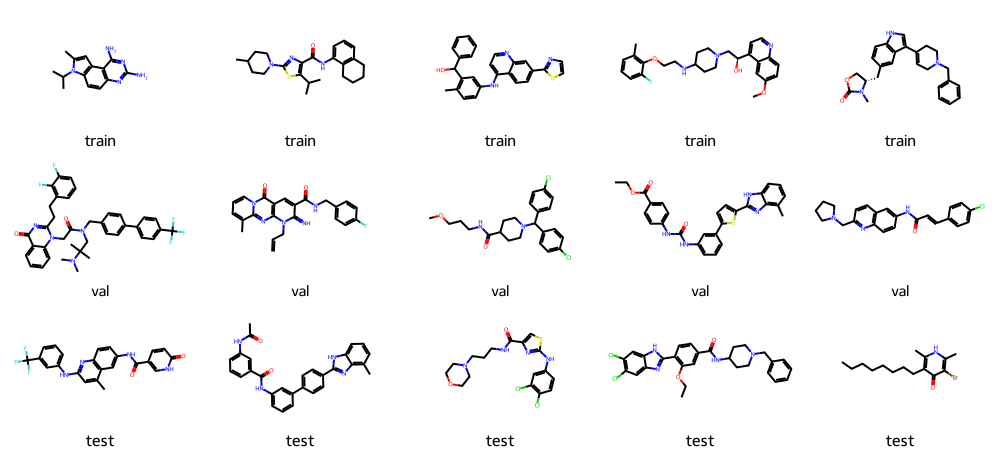

In [14]:
Draw.MolsToGridImage(sample(train_mols, 5) + sample(val_mols, 5) + sample(test_mols, 5)
                     , molsPerRow=5, subImgSize=(200, 150)
                     , legends=['train'] * 5 + ['val'] * 5 + ['test'] * 5, highlightAtomLists=None)

<h4 style="font-family: cursive">Featurization and Loaders</h4>

In [15]:
%%time
# features_ = None
features_ = [
                'CalcExactMolWt'
                , 'CalcTPSA', 'CalcNumAromaticRings', 'CalcNumHBA', 'CalcNumHBD'
                , 'CalcNumRotatableBonds'
                # , 'CalcChi0n', 'CalcChi0v', 'CalcChi1n', 'CalcChi1v', 'CalcChi2n', 'CalcChi2v'
                # , 'CalcChi3n', 'CalcChi3v', 'CalcChi4n', 'CalcChi4v', 'CalcChi0n', 'CalcChi0v'
                , 'MolLogP', 'HallKierAlpha', 'qed', 'MaxPartialCharge', 'MinPartialCharge'
                # , 'ZagrebIndex'
                , 'MoeType'
            
            ]

mol_featurizer = featurizers.MoleculeFeaturizer(features = features_, df_func_gps=featurizers.DF_FUNC_GRPS_MINI) # featurizers.DF_FUNC_GRPS

train_dataset  = gnn_utils.get_dataset_from_mol_list(mol_list=train_mols[:], targets=y_train[:]
                                                    , atom_featurizer=atom_featurizer, bond_featurizer=bond_featurizer
                                                    , mol_featurizer=mol_featurizer
                                                    , add_explicit_h=False, compute_global_features=True
                                                    , add_global_feat_to_nodes=False)

# print(train_dataset[1].x, train_dataset[1].y, train_dataset[1].x[0].shape) 
# if 'global_feats' in train_dataset[1].to_dict():
#     print( train_dataset[1].global_feats)
# train_dataset[1].x[5:10]

# s = mol_featurizer.compute_rdkit_properties(train_mols[0])
# s

train_dataset[1].x.shape, len(featurizers.DF_FUNC_GRPS_MINI)

RDKIT property calculation: 55.373 seconds.


100%|██████████| 10816/10816 [00:21<00:00, 499.37it/s]


MORDRED property calculation: 22.351 seconds.
len_mol_features: 10816
CPU times: user 1min 20s, sys: 5.23 s, total: 1min 26s
Wall time: 1min 29s


(torch.Size([22, 55]), 40)

In [16]:
val_dataset = gnn_utils.get_dataset_from_mol_list(mol_list=val_mols, targets=y_val
                                                    , atom_featurizer=atom_featurizer, bond_featurizer=bond_featurizer
                                                    , mol_featurizer=mol_featurizer
                                                    , add_explicit_h=False, compute_global_features=True
                                                    , add_global_feat_to_nodes=False)

test_dataset = gnn_utils.get_dataset_from_mol_list(mol_list=test_mols, targets=y_test
                                                    , atom_featurizer=atom_featurizer, bond_featurizer=bond_featurizer
                                                    , mol_featurizer=mol_featurizer
                                                    , add_explicit_h=False, compute_global_features=True
                                                    , add_global_feat_to_nodes=False)


                                                

RDKIT property calculation: 10.285 seconds.


100%|██████████| 2028/2028 [00:12<00:00, 164.03it/s]


MORDRED property calculation: 4.137 seconds.
len_mol_features: 2028
RDKIT property calculation: 11.258 seconds.


100%|██████████| 676/676 [00:01<00:00, 466.98it/s]


MORDRED property calculation: -6.805 seconds.
len_mol_features: 676


In [17]:
dd2_dataset_fname = f'{DATASET_DIR}/dd2_datasets.pt'
torch.save({'train_dataset':train_dataset, 'val_dataset':val_dataset, 'test_dataset':test_dataset}, dd2_dataset_fname)    

In [18]:

batch_size=512
train_loader, val_loader, test_loader = datasets.get_dataloaders(train_data=train_dataset, test_data=test_dataset
                                                                 , val_data=val_dataset, batch_size=batch_size, shuffle_train=True
                                                                 , add_global_feats_to_nodes=True, num_workers=0
                                                                 , scale_features=True, feature_scaler=StandardScaler())


# list(train_loader)[0].x[0].shape

dd2_loader_fname = f'{DATASET_DIR}/dd2_dataloaders.pt'
torch.save({'train_loader':train_loader, 'val_loader':val_loader, 'test_loader':test_loader}, dd2_loader_fname)    

gfeatures_cleaned (10816, 104)
gfeatures_cleaned (676, 104)
gfeatures_cleaned (2028, 104)


<h3 style="font-family: cursive">Hyperparameter Tuning</h4>

In [19]:
in_channels = list(train_loader)[0].x[0].shape[0]

print(list(train_dataset[:2]))
print(list(train_loader)[0])
print(list(train_loader)[0].to_dict().keys())
global_fdim = None if list(train_loader)[0].to_dict().get('global_feats', None) is None else list(train_loader)[0].global_feats.shape[1]
print(global_fdim)

[Data(x=[23, 55], edge_index=[2, 73], edge_attr=[73, 11], global_feats=[104], y=[1]), Data(x=[22, 55], edge_index=[2, 70], edge_attr=[70, 11], global_feats=[104], y=[1])]
DataBatch(x=[16270, 159], edge_index=[2, 51822], edge_attr=[51822, 11], y=[512], batch=[16270], ptr=[513])
dict_keys(['x', 'edge_index', 'edge_attr', 'y', 'batch', 'ptr'])
None


In [20]:
%%time 
import sklearn

criterion   = BCELoss()


exp_params_grid = {
    'task': 'binary_classification',
    'in_channels' : in_channels, 'global_fdim' : global_fdim,
    'model': ['graph_nns.GCN', 'graph_nns.GAT'], #
    # 'gnn_hidden_neurons': [128, 256, 384, 512]
    'gnn_hidden_neurons': [150, 500]
    , 'gnn_nlayers':[3, 6]
    # , 'ffn_hidden_neurons': [64, 128, 256, 384, 512]
    , 'ffn_hidden_neurons': [100, 500]
    , 'ffn_nlayers': [1, 2], 'out_neurons':1, 'dropout_rate': [0.1, 0.6]
    , 'activation_func': ['torch.nn.LeakyReLU', 'torch.nn.ReLU'], 'gpooling_func' : ['mean']
    , 'heads' : [4,8]
    , 'edge_dim': [2,8]
    , 'add_edge_features': False
    
    , 'learning_rate': [5e-2, 1e-2], 'n_epochs': [150, 500] 
    , 'criterion' : criterion
    , 'optimizer' : ["{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}"]
    #, 'scheduler' : ["{'lr_scheduler_type':'lr_scheduler.ReduceLROnPlateau', 'mode':'min', 'factor':0.7, 'patience':30, 'threshold':5e-02, 'eps':1e-08}"], 
    , 'scheduler' : ["{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}"]
    , 'scoring_func': ['roc_auc_score']
    , 'add_batch_norm':True

}


my_hpo = training_utils.OptunaHPO(n_trials=6, n_jobs=1, sampler=None)

results = my_hpo.run_optimization(   
        train_val_data= [train_loader, val_loader]
        , params_grid=exp_params_grid
        , optuna_direction='maximize'
        , split_mode='classic'
        , study_name='my_gcn_study'
)

results

[I 2024-10-21 21:57:27,199] A new study created in memory with name: my_gcn_study


params = {'task': 'binary_classification', 'in_channels': 159, 'global_fdim': None, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 310, 'gnn_nlayers': 6, 'ffn_hidden_neurons': 148, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.172654360046017, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'heads': 5, 'edge_dim': 5, 'add_edge_features': False, 'learning_rate': 0.027368015498220218, 'n_epochs': 200, 'criterion': BCELoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}
params =  {'task': 'binary_classification', 'in_channels': 159, 'global_fdim': None, 'gnn_hidden_neurons': 310, 'gnn_nlayers': 6, 'ffn_hidden_neurons': 148, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.172654360046017, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'add_batch_no

[I 2024-10-21 22:01:56,721] Trial 0 finished with value: 0.8575533111056667 and parameters: {'in_channels': 159, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 310, 'gnn_nlayers': 6, 'ffn_hidden_neurons': 148, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.172654360046017, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'heads': 5, 'edge_dim': 5, 'learning_rate': 0.027368015498220218, 'n_epochs': 200, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score'}. Best is trial 0 with value: 0.8575533111056667.



===> Epoch  200/200: Average Train Loss: 0.144 |  Average validation Loss: 0.754 | Validation Score: 0.858 | lr: 0.07579
params = {'task': 'binary_classification', 'in_channels': 159, 'global_fdim': None, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 326, 'gnn_nlayers': 3, 'ffn_hidden_neurons': 212, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.3589347399029237, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'heads': 8, 'edge_dim': 7, 'add_edge_features': False, 'learning_rate': 0.0410213364221023, 'n_epochs': 250, 'criterion': BCELoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}
params =  {'task': 'binary_classification', 'in_channels': 159, 'global_fdim': None, 'gnn_hidden_neurons': 326, 'gnn_nlayers': 3, 'ffn_hidden_neurons': 212, 'ffn_nlayers': 2, '

[I 2024-10-21 22:06:11,900] Trial 1 finished with value: 0.8375370358229296 and parameters: {'in_channels': 159, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 326, 'gnn_nlayers': 3, 'ffn_hidden_neurons': 212, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.3589347399029237, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'heads': 8, 'edge_dim': 7, 'learning_rate': 0.0410213364221023, 'n_epochs': 250, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score'}. Best is trial 0 with value: 0.8575533111056667.



===> Epoch  250/250: Average Train Loss: 0.156 |  Average validation Loss: 0.737 | Validation Score: 0.838 | lr: 0.08034
params = {'task': 'binary_classification', 'in_channels': 159, 'global_fdim': None, 'model': 'graph_nns.GAT', 'gnn_hidden_neurons': 182, 'gnn_nlayers': 5, 'ffn_hidden_neurons': 372, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.524877226516699, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'heads': 4, 'edge_dim': 4, 'add_edge_features': False, 'learning_rate': 0.04309858232417133, 'n_epochs': 300, 'criterion': BCELoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}
Initializing parameters...
	optimizer:  {'state': {}, 'param_groups': [{'lr': 0.04309858232417133, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': False, 'maximize

[I 2024-10-21 22:33:31,716] Trial 2 finished with value: 0.8281078308424273 and parameters: {'in_channels': 159, 'model': 'graph_nns.GAT', 'gnn_hidden_neurons': 182, 'gnn_nlayers': 5, 'ffn_hidden_neurons': 372, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.524877226516699, 'activation_func': 'torch.nn.ReLU', 'gpooling_func': 'mean', 'heads': 4, 'edge_dim': 4, 'learning_rate': 0.04309858232417133, 'n_epochs': 300, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score'}. Best is trial 0 with value: 0.8575533111056667.



===> Epoch  300/300: Average Train Loss: 3.345 |  Average validation Loss: 3.941 | Validation Score: 0.828 | lr: 0.04310
params = {'task': 'binary_classification', 'in_channels': 159, 'global_fdim': None, 'model': 'graph_nns.GAT', 'gnn_hidden_neurons': 230, 'gnn_nlayers': 6, 'ffn_hidden_neurons': 340, 'ffn_nlayers': 1, 'out_neurons': 1, 'dropout_rate': 0.5463262403665002, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'heads': 8, 'edge_dim': 8, 'add_edge_features': False, 'learning_rate': 0.012618966705115212, 'n_epochs': 250, 'criterion': BCELoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}
Initializing parameters...
	optimizer:  {'state': {}, 'param_groups': [{'lr': 0.012618966705115212, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': False, '

[I 2024-10-22 04:00:47,409] Trial 3 finished with value: 0.8587072065391137 and parameters: {'in_channels': 159, 'model': 'graph_nns.GAT', 'gnn_hidden_neurons': 230, 'gnn_nlayers': 6, 'ffn_hidden_neurons': 340, 'ffn_nlayers': 1, 'out_neurons': 1, 'dropout_rate': 0.5463262403665002, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'heads': 8, 'edge_dim': 8, 'learning_rate': 0.012618966705115212, 'n_epochs': 250, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score'}. Best is trial 3 with value: 0.8587072065391137.



===> Epoch  250/250: Average Train Loss: 3.355 |  Average validation Loss: 3.639 | Validation Score: 0.859 | lr: 0.07087
params = {'task': 'binary_classification', 'in_channels': 159, 'global_fdim': None, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 310, 'gnn_nlayers': 5, 'ffn_hidden_neurons': 260, 'ffn_nlayers': 1, 'out_neurons': 1, 'dropout_rate': 0.5792942355454156, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'heads': 6, 'edge_dim': 3, 'add_edge_features': False, 'learning_rate': 0.018068342979022683, 'n_epochs': 300, 'criterion': BCELoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}
params =  {'task': 'binary_classification', 'in_channels': 159, 'global_fdim': None, 'gnn_hidden_neurons': 310, 'gnn_nlayers': 5, 'ffn_hidden_neurons': 260, 'ffn_nlayers': 1,

[I 2024-10-22 04:07:19,641] Trial 4 finished with value: 0.756024506105448 and parameters: {'in_channels': 159, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 310, 'gnn_nlayers': 5, 'ffn_hidden_neurons': 260, 'ffn_nlayers': 1, 'out_neurons': 1, 'dropout_rate': 0.5792942355454156, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'heads': 6, 'edge_dim': 3, 'learning_rate': 0.018068342979022683, 'n_epochs': 300, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score'}. Best is trial 3 with value: 0.8587072065391137.



===> Epoch  300/300: Average Train Loss: 0.062 |  Average validation Loss: 10.662 | Validation Score: 0.756 | lr: 0.01807
params = {'task': 'binary_classification', 'in_channels': 159, 'global_fdim': None, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 342, 'gnn_nlayers': 4, 'ffn_hidden_neurons': 404, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.5797774603801864, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'heads': 8, 'edge_dim': 6, 'add_edge_features': False, 'learning_rate': 0.01373439713732089, 'n_epochs': 450, 'criterion': BCELoss(), 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score', 'add_batch_norm': True}
params =  {'task': 'binary_classification', 'in_channels': 159, 'global_fdim': None, 'gnn_hidden_neurons': 342, 'gnn_nlayers': 4, 'ffn_hidden_neurons': 404, 'ffn_nlayers': 2,

[I 2024-10-22 04:16:50,099] Trial 5 finished with value: 0.910683578259321 and parameters: {'in_channels': 159, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 342, 'gnn_nlayers': 4, 'ffn_hidden_neurons': 404, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.5797774603801864, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'heads': 8, 'edge_dim': 6, 'learning_rate': 0.01373439713732089, 'n_epochs': 450, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score'}. Best is trial 5 with value: 0.910683578259321.



===> Epoch  450/450: Average Train Loss: 0.056 |  Average validation Loss: 0.469 | Validation Score: 0.911 | lr: 0.01373
CPU times: user 6h 17min 33s, sys: 2min 2s, total: 6h 19min 35s
Wall time: 6h 19min 23s


{'best_params': {'in_channels': 159,
  'model': 'graph_nns.GCN',
  'gnn_hidden_neurons': 342,
  'gnn_nlayers': 4,
  'ffn_hidden_neurons': 404,
  'ffn_nlayers': 2,
  'out_neurons': 1,
  'dropout_rate': 0.5797774603801864,
  'activation_func': 'torch.nn.LeakyReLU',
  'gpooling_func': 'mean',
  'heads': 8,
  'edge_dim': 6,
  'learning_rate': 0.01373439713732089,
  'n_epochs': 450,
  'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}",
  'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}",
  'scoring_func': 'roc_auc_score'},
 'best_score': 0.910683578259321}

<h3 style="font-family: cursive">Training and Evaluating The Best Model</h3>

In [21]:
best_params = results['best_params']
best_params.update(**{'task':'binary_classification'})
print("Best params: ", best_params)
# gcn_model = graph_nns.GCN.from_dict(results['best_params'])
# gcn_model

gcn_model = eval(best_params['model']).from_dict({
    "task" : best_params['task']
    , 'in_channels': best_params['in_channels'],  'gnn_hidden_neurons' : int(best_params['gnn_hidden_neurons'])
    , 'gnn_nlayers' : best_params['gnn_nlayers'], 'global_fdim' : best_params.get('global_fdim', None)
    , 'ffn_hidden_neurons' :int(best_params['ffn_hidden_neurons']), 'ffn_nlayers' : best_params['ffn_nlayers']
    , 'out_neurons' : best_params['out_neurons'], 'dropout_rate' : best_params['dropout_rate']
    , 'gpooling_func' : best_params['gpooling_func'], 'activation_func' : best_params['activation_func']
    , 'add_batch_norm' : True
})


Best params:  {'in_channels': 159, 'model': 'graph_nns.GCN', 'gnn_hidden_neurons': 342, 'gnn_nlayers': 4, 'ffn_hidden_neurons': 404, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.5797774603801864, 'activation_func': 'torch.nn.LeakyReLU', 'gpooling_func': 'mean', 'heads': 8, 'edge_dim': 6, 'learning_rate': 0.01373439713732089, 'n_epochs': 450, 'optimizer': "{'optimizer_type':'torch.optim.SGD', 'weight_decay':1e-3}", 'scheduler': "{'lr_scheduler_type':'lr_scheduler.CyclicLR', 'max_lr':0.1, 'step_size_up':75, 'cycle_momentum':True}", 'scoring_func': 'roc_auc_score', 'task': 'binary_classification'}
params =  {'task': 'binary_classification', 'in_channels': 159, 'gnn_hidden_neurons': 342, 'gnn_nlayers': 4, 'global_fdim': None, 'ffn_hidden_neurons': 404, 'ffn_nlayers': 2, 'out_neurons': 1, 'dropout_rate': 0.5797774603801864, 'gpooling_func': 'mean', 'activation_func': 'torch.nn.LeakyReLU', 'add_batch_norm': True}
Initializing parameters...


<h4 style="font-family: cursive"> Model Training</h4>

In [22]:
gnn_trainer = training_utils.GNNTrainer(task=best_params['task'], model=gcn_model
                                            , scheduler=best_params['scheduler']
                                            , optimizer=best_params['optimizer']
                                            , criterion=criterion
                                            , scoring_func=eval(best_params['scoring_func'])
                                            , n_epochs=best_params['n_epochs']
                                            , learning_rate=best_params['learning_rate']
                                        )
gnn_trainer.__dict__

	optimizer:  {'state': {}, 'param_groups': [{'lr': 0.01373439713732089, 'momentum': 0, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]}
	lr_scheduler:  {'max_lrs': [0.1], 'total_size': 150.0, 'step_ratio': 0.5, 'mode': 'triangular', 'gamma': 1.0, '_scale_fn_custom': None, 'scale_mode': 'cycle', 'cycle_momentum': True, 'base_momentums': [0.8], 'max_momentums': [0.9], 'base_lrs': [0.01373439713732089], 'last_epoch': 0, 'verbose': False, '_step_count': 1, '_get_lr_called_within_step': False, '_last_lr': [0.01373439713732089]}
checkpoint dir: None


{'task': 'binary_classification',
 'model': GCN(
   (activation_func): LeakyReLU(negative_slope=0.01)
   (cassification_out_layer): Sigmoid()
   (conv1): GCNConv(159, 342)
   (convs): ModuleList(
     (0-2): 3 x GCNConv(342, 342)
   )
   (ffn): Sequential(
     (0): Dropout(p=0.5797774603801864, inplace=False)
     (1): Linear(in_features=342, out_features=404, bias=True)
     (2): BatchNorm1d(404, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): LeakyReLU(negative_slope=0.01)
     (4): Dropout(p=0.5797774603801864, inplace=False)
   )
   (final): Linear(in_features=404, out_features=1, bias=True)
 ),
 'learning_rate': 0.01373439713732089,
 'n_epochs': 450,
 'optimizer': SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     initial_lr: 0.01373439713732089
     lr: 0.01373439713732089
     maximize: False
     momentum: 0.9
     nesterov: False
     weight_decay: 0.001
 ),
 'scheduler': <torch.optim.lr_scheduler.CyclicLR a

In [23]:
%%time
train_losses, val_losses, val_scores = gnn_trainer.train(train_loader=train_loader, val_loader=val_loader)

device = cuda
TASK: binary_classification

===> Epoch    1/450: Average Train Loss: 0.841 |  Average validation Loss: 0.667 | Validation Score: 0.602 | lr: 0.01488

===> Epoch   21/450: Average Train Loss: 0.506 |  Average validation Loss: 0.617 | Validation Score: 0.736 | lr: 0.03789

===> Epoch   41/450: Average Train Loss: 0.372 |  Average validation Loss: 0.630 | Validation Score: 0.752 | lr: 0.06089

===> Epoch   61/450: Average Train Loss: 0.304 |  Average validation Loss: 0.774 | Validation Score: 0.784 | lr: 0.08390

===> Epoch   81/450: Average Train Loss: 0.269 |  Average validation Loss: 0.699 | Validation Score: 0.798 | lr: 0.09310

===> Epoch  101/450: Average Train Loss: 0.202 |  Average validation Loss: 0.676 | Validation Score: 0.815 | lr: 0.07009

===> Epoch  121/450: Average Train Loss: 0.156 |  Average validation Loss: 0.570 | Validation Score: 0.859 | lr: 0.04709

===> Epoch  141/450: Average Train Loss: 0.103 |  Average validation Loss: 0.442 | Validation Score: 0.

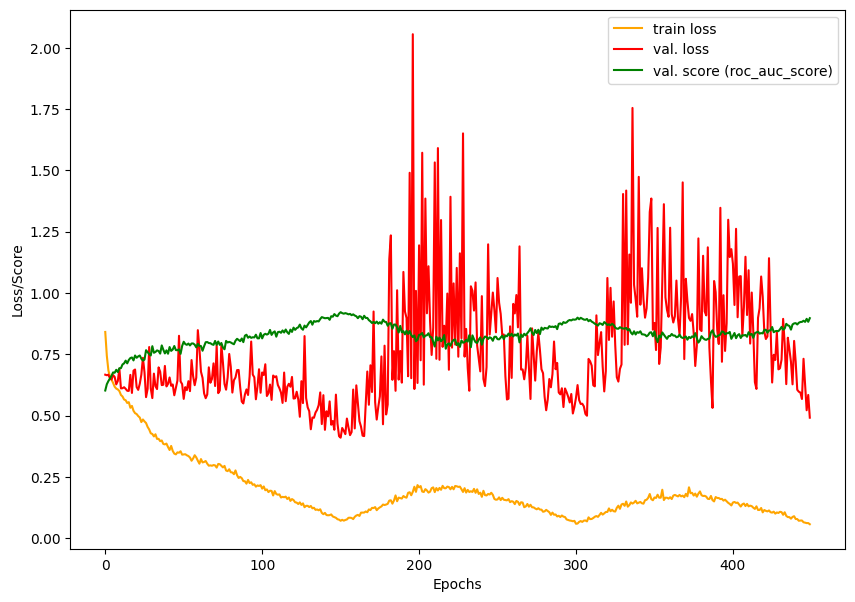

In [24]:

utilities.plots_train_val_metrics(train_losses=train_losses, val_scores=val_scores
                                    , val_losses=val_losses, figsize=(10, 7)
                                    , image_pathname=f"{DATASET_DIR}/figures/dd2_class_gcn_stats.jpeg"
                                    , val_score_name=best_params['scoring_func']
                                )


In [25]:
torch.save(gcn_model, f"{DATASET_DIR}/models/dd2_class_gcn_model.pt")

<h4 style="font-family: cursive"> Model Evaluation</h4>

In [26]:
from lib import predictions
test_pred, test_true = predictions.predict_from_loader(loader=test_loader, model=gcn_model
                                                     , device='cuda:0'
                                                     , return_true_targets=True, desc="Predicting...")

threshold = 0.5
test_pred_classes = [int(x>threshold) for x in test_pred.squeeze(1)] 

# print(test_pred)
print(test_pred_classes)

print(f"\nROC AUC Score = {round(roc_auc_score(test_true.cpu(), test_pred.detach().cpu()),3)}")
print(f"Balanced Acc. = {round(balanced_accuracy_score(test_true.cpu(), test_pred_classes),3)}")
print(f"F1-Score      = {round(f1_score(test_true.cpu(), test_pred_classes),3)}")
print(f"Precision     = {round(precision_score(test_true.cpu(), test_pred_classes),3)}")
print(f"Recall        = {round(recall_score(test_true.cpu(), test_pred_classes),3)}")

[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 

<h5 style="font-family: cursive"> Evaluate using the GNNPredictor</h5>

In [27]:
# print(dir(atom_featurizer))
# print(atom_featurizer.features_mapping)
gcn_predictor = predictions.GNNPredictor(model=gcn_model, atom_featurizer=atom_featurizer
                                        , bond_featurizer=bond_featurizer, add_explicit_h=True
                                        , mol_featurizer=mol_featurizer
                                        , scale_features=True, feature_scaler=StandardScaler()
                                        , compute_global_features=True, add_global_feats_to_nodes=True)




In [28]:
# # gcn_model = torch.load(f"{DATASET_DIR}/models/dd2_class_gcn_model.pt")
torch.save(gcn_predictor, f"{DATASET_DIR}/models/dd2_class_gcn_predictor.pt")


In [29]:
# gcn_predictor=torch.load(f"{DATASET_DIR}/models/dd2_class_gcn_predictor.pt")
# gcn_predictor

# dd2_loader_fname = f'{DATASET_DIR}/dd2_dataloaders.pt'
# dd2_loaders = torch.load(dd2_loader_fname)  

# train_loader = dd2_loaders['train_loader']
# val_loader   = dd2_loaders['val_loader']
# test_loader  = dd2_loaders['test_loader']

In [30]:
test_pred, test_true = gcn_predictor.predict_from_loader(loader=test_loader
                                                     , device='cuda:0', return_true_targets=True, desc="Predicting...")


### Let's try a higher threshold
threshold = 0.7



test_pred_classes = [int(x>threshold) for x in test_pred.squeeze(1)] 
print(test_pred_classes)

print(f"\nROC AUC Score = {round(roc_auc_score(test_true.cpu(), test_pred.detach().cpu()),3)}")
print(f"Balanced Acc. = {round(balanced_accuracy_score(test_true.cpu(), test_pred_classes),3)}")
print(f"F1-Score      = {round(f1_score(test_true.cpu(), test_pred_classes),3)}")
print(f"Precision     = {round(precision_score(test_true.cpu(), test_pred_classes),3)}")
print(f"Recall        = {round(recall_score(test_true.cpu(), test_pred_classes),3)}")

[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 

In [31]:
### Here, we use the test_dataset instead of the loader, just to make sure the predictor 
# works as expeted. We must get the same values as earlier.

print(len(test_dataset))

# test_ld_min= datasets.get_dataloader(dataset=test_dataset[:], batch_size=512, shuffle=False
#                    , add_global_feats_to_nodes=False, num_workers=0
#                    , scale_features=False, feature_scaler=None)


test_pred, test_true = gcn_predictor.predict_from_data_list(data=test_dataset[:], batch_size=batch_size
                                                     , device='cuda:0', return_true_targets=True, desc="Predicting...")

# print(test_pred[:12])
# print(test_true[:12])
threshold = 0.5
test_pred_classes = [int(x>threshold) for x in test_pred.squeeze(1)] 
print(test_pred_classes)

print(f"\nROC AUC Score = {round(roc_auc_score(test_true.cpu(), test_pred.detach().cpu()),3)}")
print(f"Balanced Acc. = {round(balanced_accuracy_score(test_true.cpu(), test_pred_classes),3)}")
print(f"F1-Score      = {round(f1_score(test_true.cpu(), test_pred_classes),3)}")
print(f"Precision     = {round(precision_score(test_true.cpu(), test_pred_classes),3)}")
print(f"Recall        = {round(recall_score(test_true.cpu(), test_pred_classes),3)}")

676
gfeatures_cleaned (676, 104)
[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 

<h5 style="font-family: cursive"> Predict DD2 Activity from SMILES</h5>

In [32]:
smiles = ['CCC(=O)NCc1nccc1CO', 'O=C(O)c1cccnc1Sc1cc(CCO)c(Cl)cc1']
new_preds = gcn_predictor.predict_from_smiles_list(smiles_list=smiles, device='cuda:0'
                                                , desc="Predicting...")

threshold = 0.5
pred_classes = [int(x>threshold) for x in new_preds.squeeze(1)]
print("\nnew_preds", new_preds.detach())
print("pred_classes", pred_classes)

RDKIT property calculation: 0.25 seconds.


100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


MORDRED property calculation: 4.518 seconds.
len_mol_features: 2
gfeatures_cleaned (2, 104)

new_preds tensor([[0.0084],
        [0.9948]], device='cuda:0')
pred_classes [0, 1]


<p style="font-family: cursive">We have trained a GCN model for predicting the DD2 activity of small molecules. The model trained models achieved a ROC AUC score, and F1-score  of 0.718, and 0.759, respectively. Exploring a larger hyperpamareter space for tuning could help improving the performance</p>

<p style="font-family: cursive">It is very helfpul for model development and use to trust the predictions. There are tools that allow to explain graph-based models. These can be helfpful as they provide an intuitive visualization and interpretability of the predictions. We use PyTorch Geometric Explainer module, in combination with NetworkX. See how it is used in the <a href="./dd2_gnn_explanation.ipynb">dd2_gnn_explanation notebook</a>.</p>